In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
import pickle
import joblib

from CliqueFinder import CliqueFinder
from pipeline_funcs import inv_func, trans_func


import matplotlib.pyplot as plt
import seaborn as sns

seed = 5

threshold = 0.6

## First look

In [2]:
!ls

API_requests_example.ipynb  ML_model_development.ipynb	README.md
CliqueFinder.py		    model_saved.pkl		requirements.txt
Dockerfile		    pipeline_funcs.py		static
filename.pkl		    __pycache__			template
main.py			    README_backup.md


In [3]:
import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [4]:
boston_dataset = load_boston(return_X_y=False)

/home/ilshatman/python_virtual_environments/python39venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets

In [5]:
boston_data = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_target =  boston_dataset.target

In [6]:
#print(boston_dataset['DESCR'])

In [7]:
boston_data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [8]:
boston_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [9]:
boston_data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

## Train test split

In [10]:
train_data, val_data, train_target, val_target = train_test_split(boston_data, 
                                                                boston_target,
                                                                test_size = 0.2, 
                                                                random_state=seed)

# EDA

<AxesSubplot:ylabel='Count'>

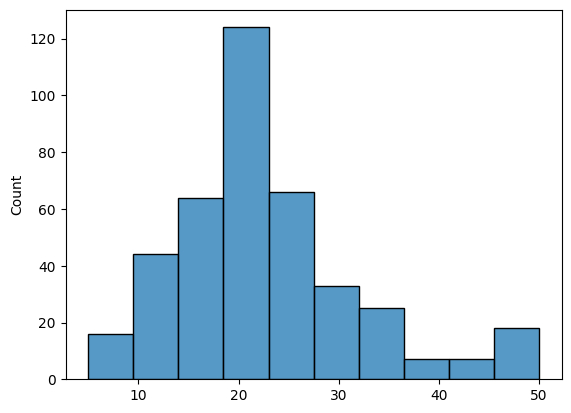

In [11]:
sns.histplot(train_target, bins = 10)

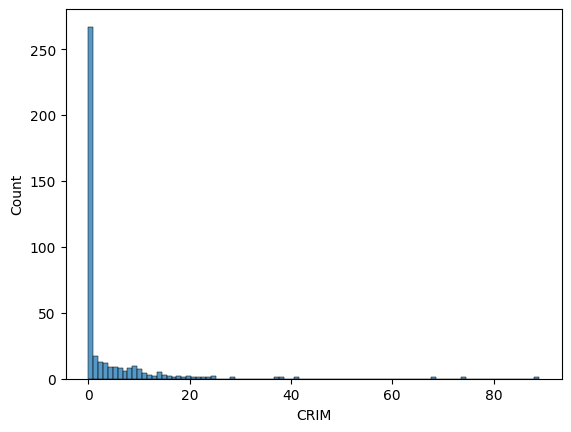

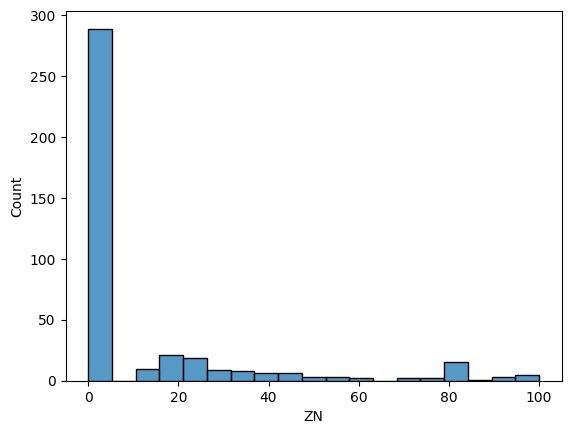

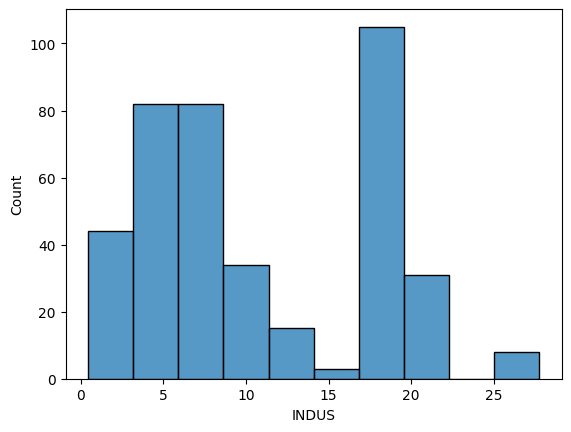

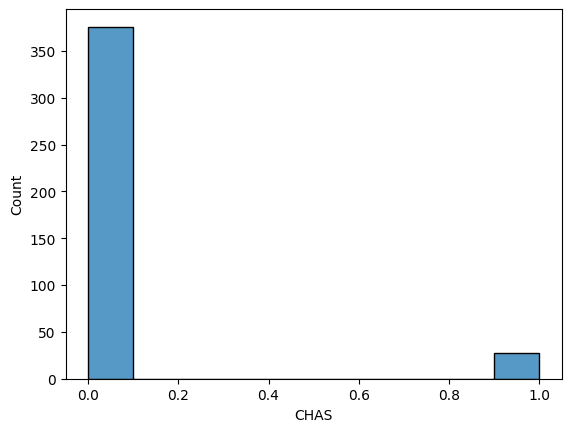

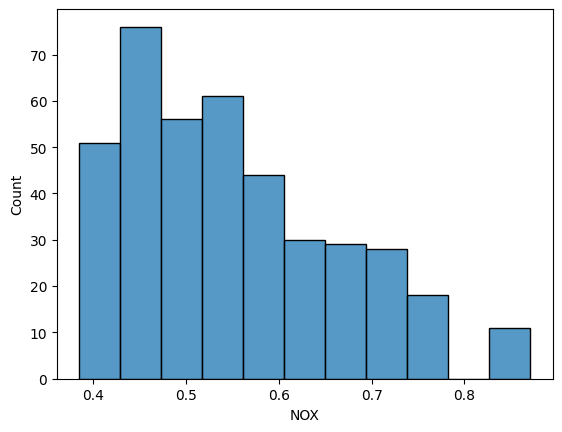

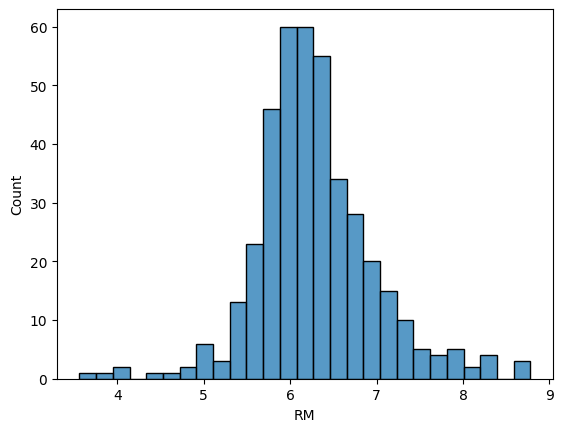

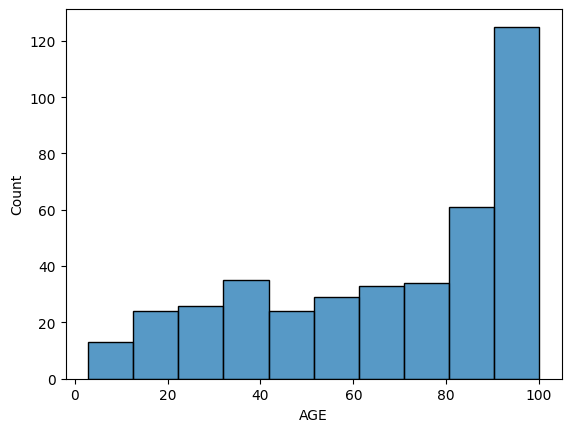

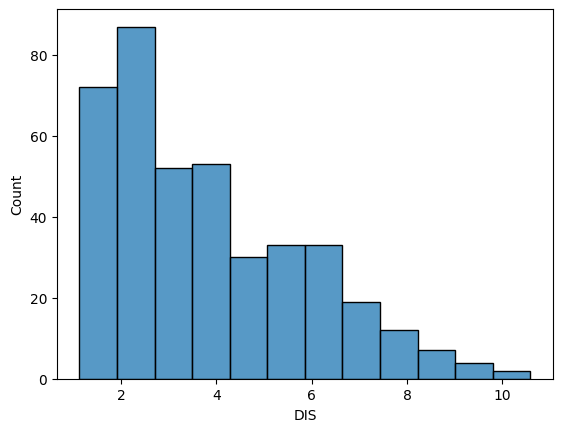

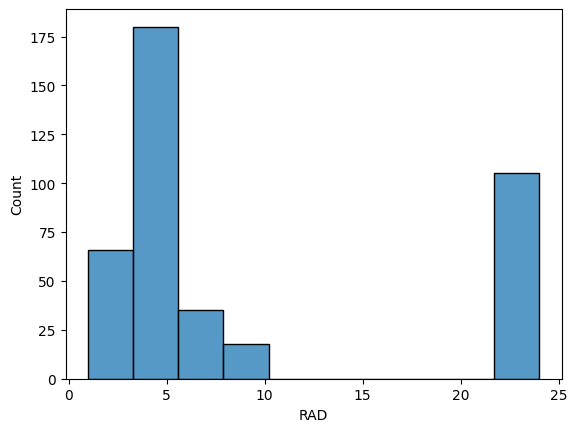

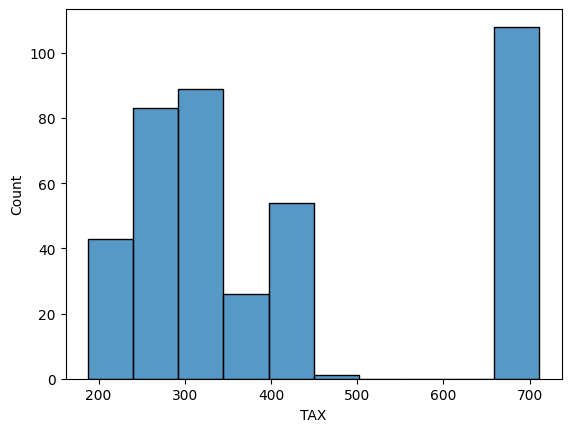

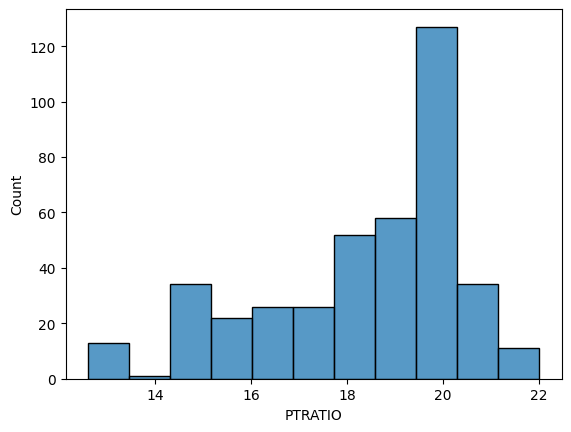

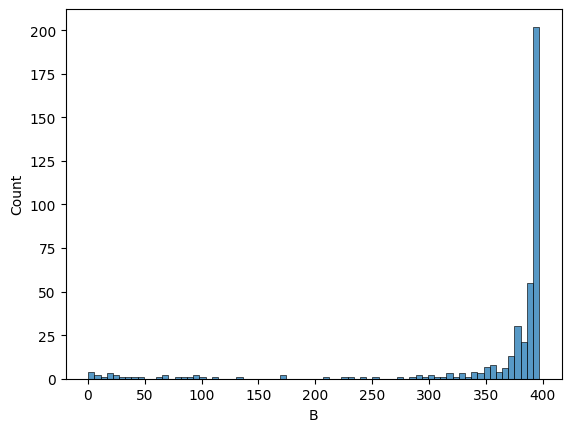

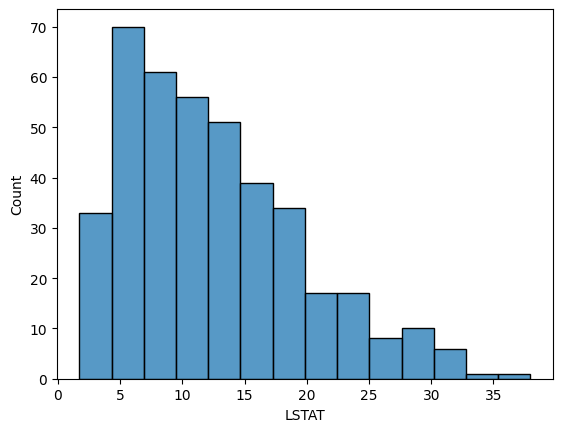

In [12]:
for feature_obj in train_data.select_dtypes(include=['int64','float64']).columns:
    sns.histplot(x=train_data[feature_obj])
    plt.show()

In [13]:
train_data['DIS'] = np.log(train_data['DIS'] + 1)
train_data['NOX'] = np.log(train_data['NOX'] + 1)

val_data['DIS'] = np.log(val_data['DIS'] + 1)
val_data['NOX'] = np.log(val_data['NOX'] + 1)

## outliers remove

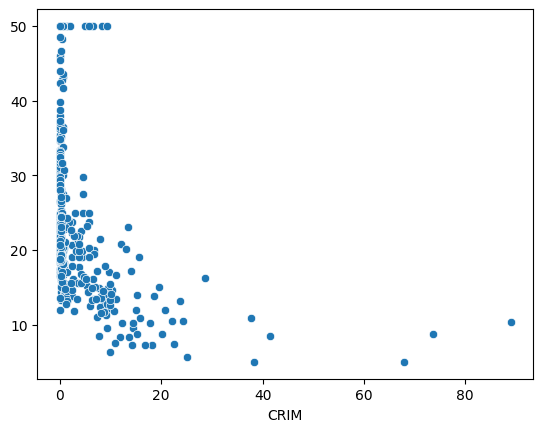

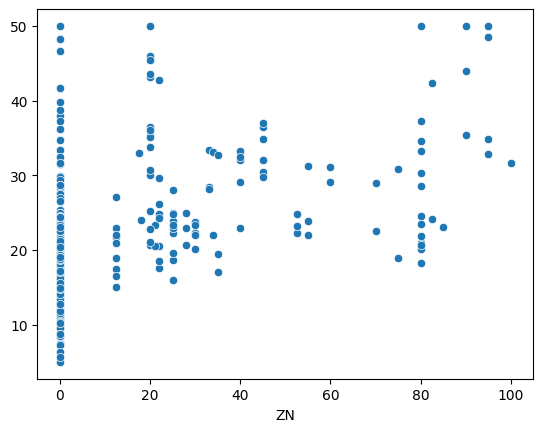

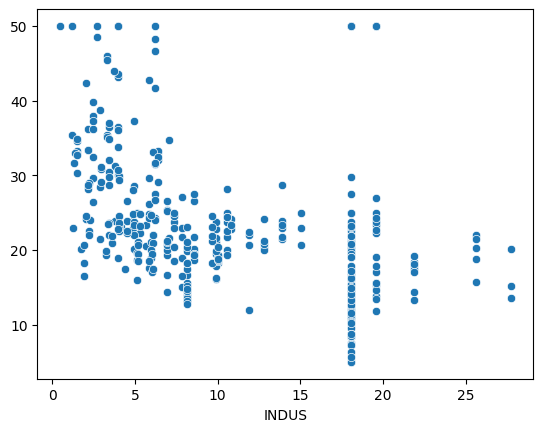

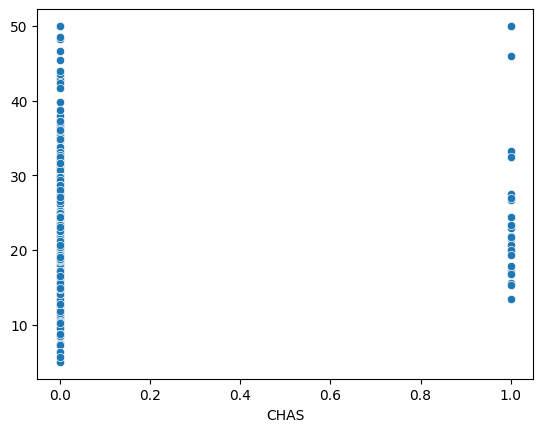

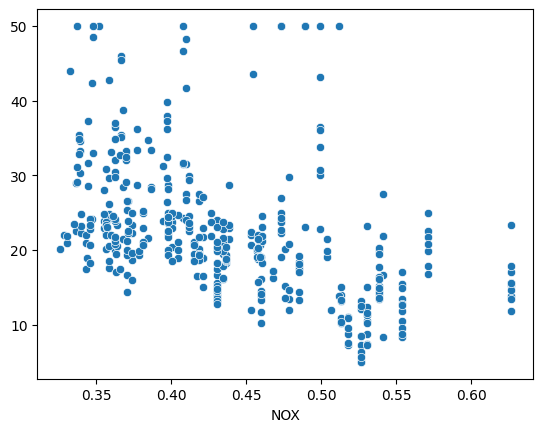

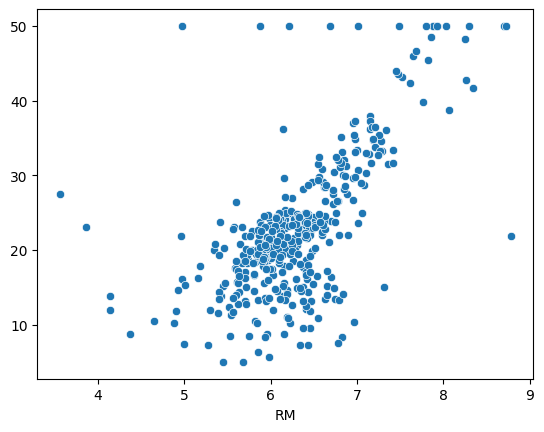

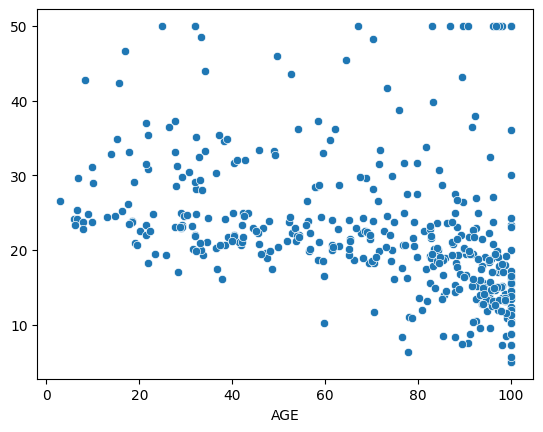

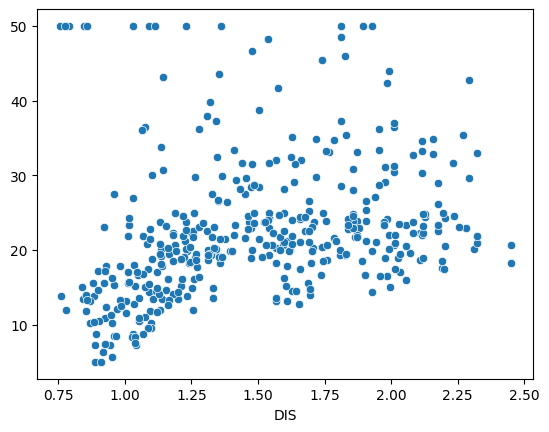

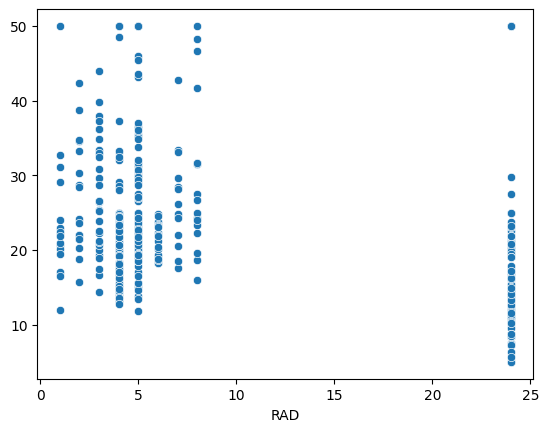

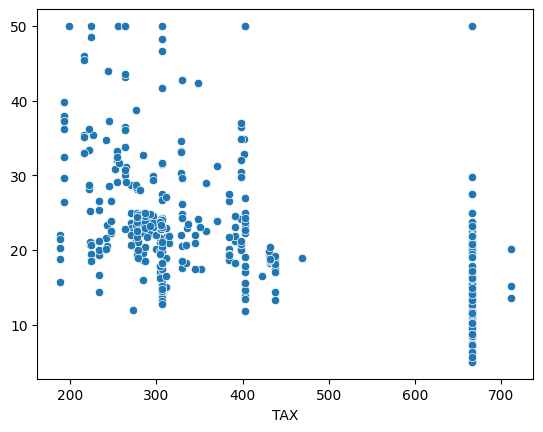

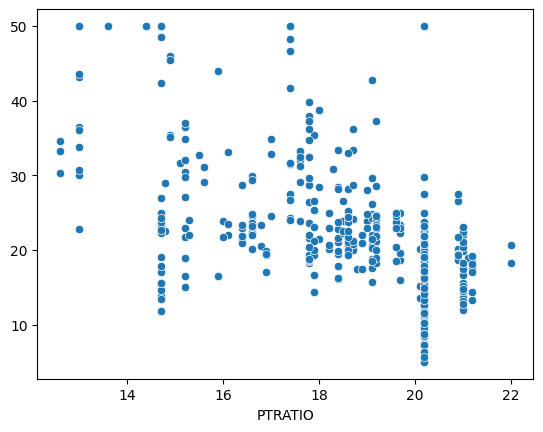

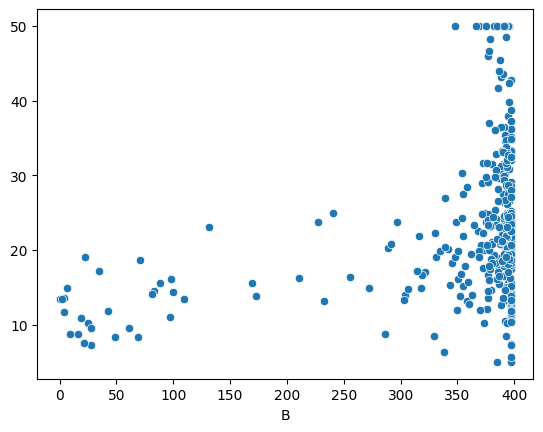

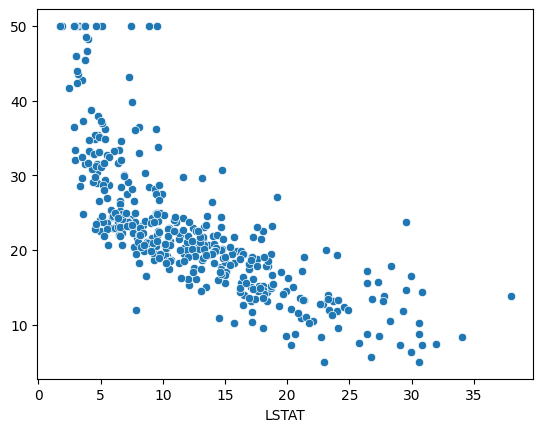

In [14]:
for feature_obj in train_data.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=train_data[feature_obj], y=train_target)
    plt.show()

In [15]:
valid_train = train_data['CRIM'] < 60
valid_validation = val_data['CRIM'] < 60
train_data = train_data[valid_train]
train_target = train_target[valid_train]
val_data = val_data[valid_validation]
val_target = val_target[valid_validation]

## Feature elimination

In [16]:
pval = 0.01
corr_threshold = 0.2
features_to_exclude = []
for feature in train_data.columns:
    result = stats.spearmanr(boston_data[feature], boston_target)
    feat_corr = result[0]
    feat_pval = result[1]
    print("name: {} corr: {} pval: {}".format(feature, feat_corr, feat_pval))
    if np.abs(feat_pval) > pval or np.abs(feat_corr) < corr_threshold:
        features_to_exclude.append(feature)

print("features to exclude : {}".format(" ".join(features_to_exclude)))

name: CRIM corr: -0.5588909488368801 pval: 6.5533358892281775e-43
name: ZN corr: 0.4381789640559852 pval: 3.740000913425908e-25
name: INDUS corr: -0.5782553852030439 pval: 1.7372313174422242e-46
name: CHAS corr: 0.14061215382621473 pval: 0.00151947934337596
name: NOX corr: -0.5626088297953195 pval: 1.4059853091979118e-43
name: RM corr: 0.6335764254337745 pval: 3.822976266954402e-58
name: AGE corr: -0.5475616874543465 pval: 6.343734710404128e-41
name: DIS corr: 0.4458568541441564 pval: 4.387641750154635e-26
name: RAD corr: -0.3467762570566875 pval: 9.604183972208833e-16
name: TAX corr: -0.5624106263737141 pval: 1.5269740805039509e-43
name: PTRATIO corr: -0.5559046822691174 pval: 2.224971669470621e-42
name: B corr: 0.18566412252480774 pval: 2.637767864062266e-05
name: LSTAT corr: -0.8529141394922163 pval: 2.221727524313283e-144
features to exclude : CHAS B


In [17]:
boston_data = boston_data.drop(columns=features_to_exclude)

In [18]:
corr_matrix = train_data.corr(method ='spearman')
# spearman pearson

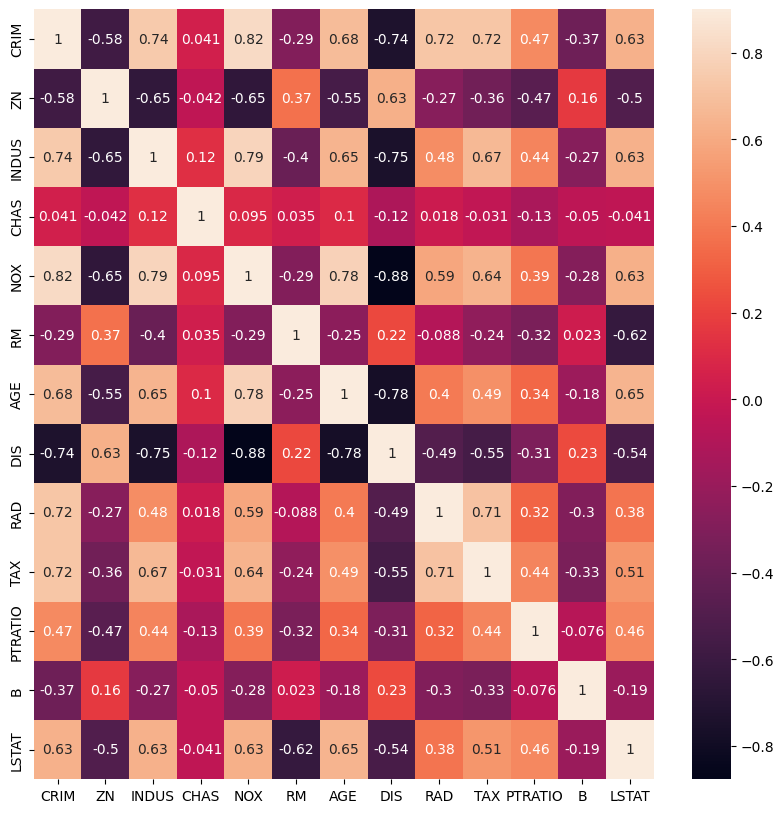

In [19]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

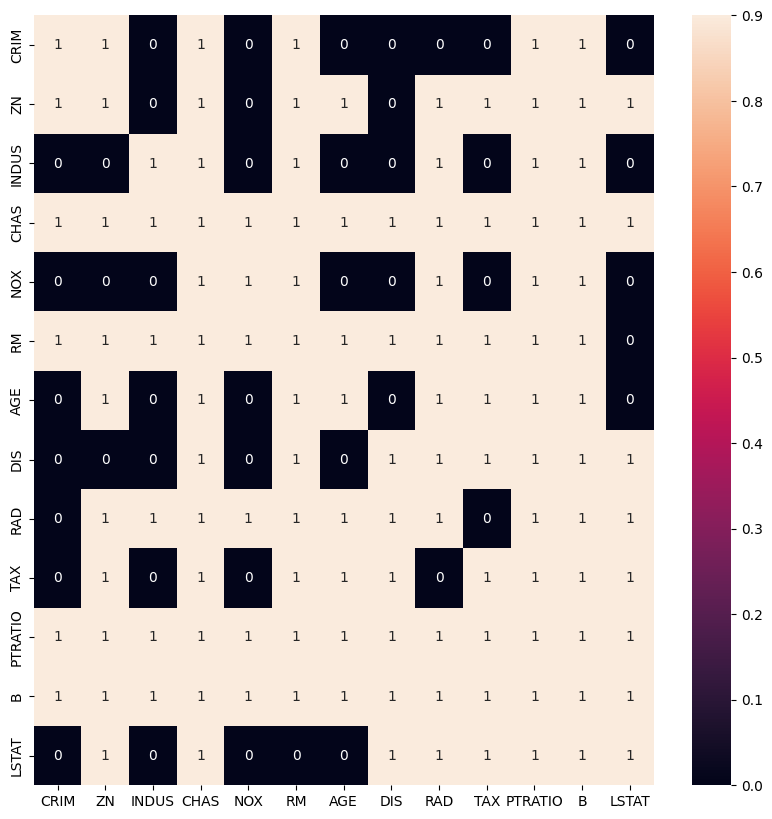

In [20]:
corr_matrix_th = corr_matrix.applymap(lambda x: 0 if (np.abs(x) > threshold) else 1)
n = len(corr_matrix_th)
for i in range(n):
    corr_matrix_th.iloc[i,i]=1
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix_th,vmax = 0.9, annot = True);

In [21]:
#corr_func = lambda x,y: stats.pearsonr(x,y)[0]
corr_func = lambda x,y: stats.spearmanr(x,y)[0] 

In [22]:
CliqFinderObj = CliqueFinder(corr_matrix, train_data, train_target)

In [23]:
CliqFinderObj.fit(feature_target_corr_func=corr_func, threshold=threshold)

In [24]:
best_features_subset = CliqFinderObj.get_best_clique()
features_to_exclude = CliqFinderObj.get_out_of_clique_features()

In [25]:
#new_boston_data = boston_data[best_features_subset]
new_train_data = train_data.drop(columns=features_to_exclude)
new_val_data = val_data.drop(columns=features_to_exclude)
new_train_data.shape

(401, 7)

In [26]:
new_corr_matrix = new_train_data.corr()

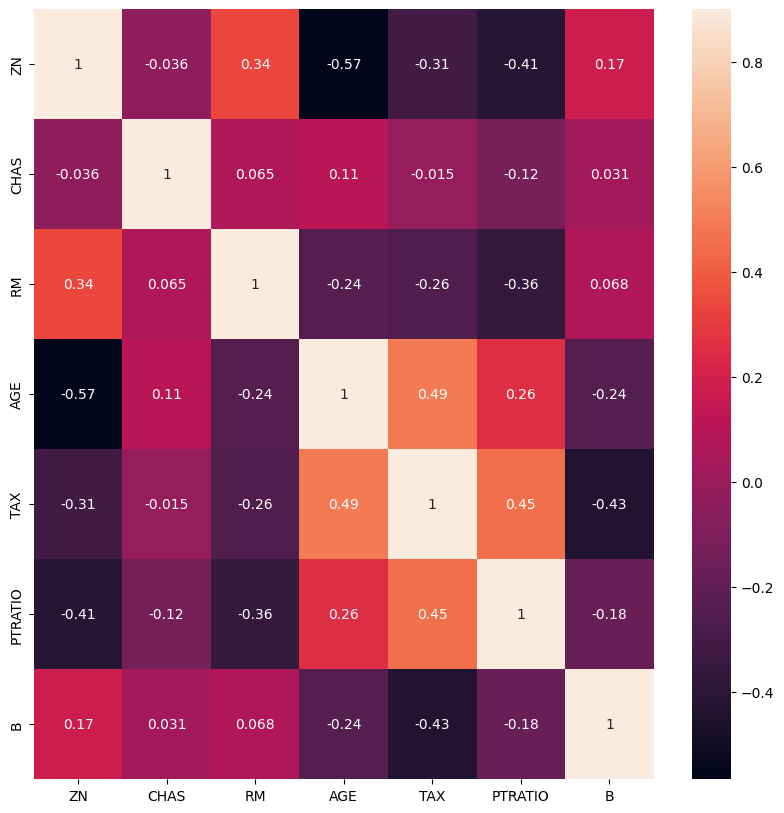

In [27]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(new_corr_matrix,vmax = 0.9, annot = True);

## Pipeline Setup & ML model train

In [28]:
all_columns = list(new_train_data.columns)
num_columns = all_columns.copy()
num_columns.remove("CHAS")

In [29]:
modifiedRegressor = TransformedTargetRegressor(
    regressor = LinearRegression(),
    func = trans_func, # lambda x: np.log(x+1),
    inverse_func = inv_func# lambda x: np.exp(x) - 1
)

feature_prepr = ColumnTransformer(
     transformers = [("numerical", StandardScaler(), num_columns)],
     remainder="passthrough"
)

pipeline = Pipeline(steps = [
    ('featurePrepr', feature_prepr),
    ('Estimator', modifiedRegressor)
])

In [30]:
pipeline.fit(new_train_data, train_target)

Pipeline(steps=[('featurePrepr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['ZN', 'RM', 'AGE', 'TAX',
                                                   'PTRATIO', 'B'])])),
                ('Estimator',
                 TransformedTargetRegressor(func=<function trans_func at 0x7fb71c409820>,
                                            inverse_func=<function inv_func at 0x7fb71bf2ef70>,
                                            regressor=LinearRegression()))])

In [31]:
prediction_value = pipeline.predict(new_val_data)
rmse = mean_squared_error(val_target, prediction_value, squared=False)
r2_score_value = r2_score(val_target, prediction_value)
print("RMSE: {} R2_Score: {}".format(rmse, r2_score_value))

RMSE: 4.037720273318705 R2_Score: 0.7917693265722578


## Post-Hoc analysis

In [32]:
error = prediction_value - val_target

<AxesSubplot:ylabel='Count'>

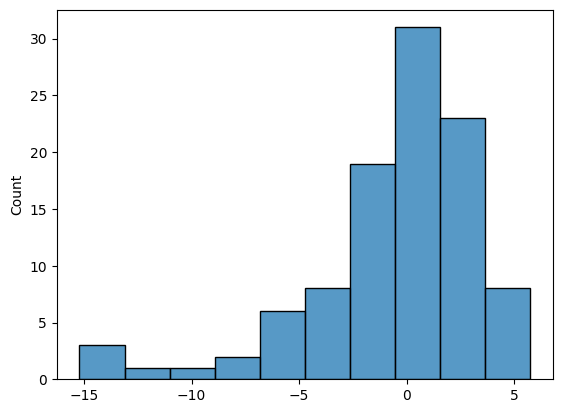

In [33]:
sns.histplot(error, bins=10)

In [34]:
new_train_data.columns

Index(['ZN', 'CHAS', 'RM', 'AGE', 'TAX', 'PTRATIO', 'B'], dtype='object')

In [35]:
len(new_train_data.columns)

7

## Save model

In [36]:
filename = 'model_saved.pkl'
with open(filename,'wb') as f:
    pickle.dump(pipeline, f)
    #joblib.dump(pipeline, 'filename.pkl')